#Trainer

In [ ]:
import numpy as np
import time

import numpy.linalg as la
import matplotlib.pyplot as plt


class Trainer:
    """
    Base class for experiments with logistic regression. Provides methods
    for running optimization methods, saving the logs and plotting the results.
    """
    def __init__(self, grad_func, loss_func, t_max=np.inf, it_max=np.inf, output_size=500, tolerance=0):
        if t_max is np.inf and it_max is np.inf:
            it_max = 100
            print('The number of iterations is set to 100.')
        self.grad_func = grad_func
        self.loss_func = loss_func
        self.t_max = t_max
        self.it_max = it_max
        self.output_size = output_size
        self.first_run = True
        self.tolerance = tolerance
        self.losses = None

    def run(self, w0):
        if self.first_run:
            self.init_run(w0)
        else:
            self.ts = list(self.ts)
            self.its = list(self.its)
            self.ws = list(self.ws)
        self.first_run = False
        while (self.it < self.it_max) and (time.time() - self.t_start < self.t_max):
            sufficiently_big_gradient = self.compute_grad()
            if not sufficiently_big_gradient:
                break
            self.estimate_stepsize()
            self.w = self.step()

            self.save_checkpoint()

        self.ts = np.array(self.ts)
        self.its = np.array(self.its)
        self.ws = np.array(self.ws)

    def compute_grad(self):
        self.grad = self.grad_func(self.w)
        return la.norm(self.grad) > self.tolerance

    def estimate_stepsize(self):
        pass

    def step(self):
        pass

    def init_run(self, w0):
        self.d = len(w0)
        self.w = w0.copy()
        self.ws = [w0.copy()]
        self.its = [0]
        self.ts = [0]
        self.it = 0
        self.t = 0
        self.t_start = time.time()
        self.time_progress = 0
        self.iterations_progress = 0
        self.max_progress = 0

    def save_checkpoint(self, first_iterations=10):
        self.it += 1
        self.t = time.time() - self.t_start
        self.time_progress = int((self.output_size - first_iterations) * self.t / self.t_max)
        self.iterations_progress = int((self.output_size - first_iterations) * (self.it / self.it_max))
        if (max(self.time_progress, self.iterations_progress) > self.max_progress) or (self.it <= first_iterations):
            self.update_logs()
        self.max_progress = max(self.time_progress, self.iterations_progress)

    def update_logs(self):
        self.ws.append(self.w.copy())
        self.ts.append(self.t)
        self.its.append(self.it)

    def compute_loss_on_iterates(self):
        self.losses = np.array([self.loss_func(w) for w in self.ws])

    def plot_losses(self, label='', marker=',', f_star=None, markevery=None):
        if self.losses is None:
            self.compute_loss_on_iterates()
        if f_star is None:
            f_star = np.min(self.losses)
        if markevery is None:
            markevery = max(1, len(self.losses) // 20)
        plt.plot(self.its, self.losses - f_star, label=label, marker=marker, markevery=markevery)

#Optimizer

In [ ]:
import numpy as np

import numpy.linalg as la




class Gd(Trainer):
    """
    Gradient descent with constant learning rate.

    Arguments:
        lr (float): an estimate of the inverse smoothness constant
    """
    def __init__(self, lr, *args, **kwargs):
        super(Gd, self).__init__(*args, **kwargs)
        self.lr = lr

    def step(self):
        return self.w - self.lr * self.grad

    def init_run(self, *args, **kwargs):
        super(Gd, self).init_run(*args, **kwargs)


class Nesterov(Trainer):
    """
    Nesterov's accelerated gradient descent with constant learning rate.

    Arguments:
        lr (float): an estimate of the inverse smoothness constant
        strongly_convex (boolean, optional): if true, uses the variant
            for strongly convex functions, which requires mu>0 (default: False)
    """
    def __init__(self, lr, strongly_convex=False, mu=0, *args, **kwargs):
        super(Nesterov, self).__init__(*args, **kwargs)
        self.lr = lr
        if mu < 0:
            raise ValueError("Invalid mu: {}".format(mu))
        if strongly_convex and mu == 0:
            raise ValueError("""Mu must be larger than 0 for strongly_convex=True,
                             invalid value: {}""".format(mu))
        if strongly_convex:
            self.mu = mu
            kappa = (1/self.lr)/self.mu
            self.momentum = (np.sqrt(kappa)-1) / (np.sqrt(kappa)+1)
        self.strongly_convex = strongly_convex

    def step(self):
        if not self.strongly_convex:
            alpha_new = 0.5 * (1 + np.sqrt(1 + 4 * self.alpha ** 2))
            self.momentum = (self.alpha - 1) / alpha_new
            self.alpha = alpha_new
        self.w_nesterov_old = self.w_nesterov.copy()
        self.w_nesterov = self.w - self.lr * self.grad
        return self.w_nesterov + self.momentum * (self.w_nesterov - self.w_nesterov_old)

    def init_run(self, *args, **kwargs):
        super(Nesterov, self).init_run(*args, **kwargs)
        self.w_nesterov = self.w.copy()
        self.alpha = 1.


class Adgd(Trainer):
    """
    Adaptive gradient descent based on the local smoothness constant

    Arguments:
        eps (float, optional): an estimate of 1 / L^2, where L is the global smoothness constant (default: 0)
    """
    def __init__(self, eps=0.0, lr0=None, *args, **kwargs):
        if not 0.0 <= eps:
            raise ValueError("Invalid eps: {}".format(eps))
        super(Adgd, self).__init__(*args, **kwargs)
        self.eps = eps
        self.lr0 = lr0

    def estimate_stepsize(self):
        L = la.norm(self.grad - self.grad_old) / la.norm(self.w - self.w_old)
        if np.isinf(self.theta):
            lr_new = 0.5 / L
        else:
            lr_new = min(np.sqrt(1 + self.theta) * self.lr, self.eps / self.lr + 0.5 / L)
        self.theta = lr_new / self.lr
        self.lr = lr_new

    def step(self):
        self.w_old = self.w.copy()
        self.grad_old = self.grad.copy()
        return self.w - self.lr * self.grad

    def init_run(self, *args, **kwargs):
        super(Adgd, self).init_run(*args, **kwargs)
        self.theta = np.inf
        grad = self.grad_func(self.w)
        if self.lr0 is None:
            self.lr0 = 1e-10
        self.lr = self.lr0
        self.lrs = [self.lr]
        self.w_old = self.w.copy()
        self.grad_old = grad
        self.w -= self.lr * grad
        self.save_checkpoint()

    def update_logs(self):
        super(Adgd, self).update_logs()
        self.lrs.append(self.lr)


class AdgdAccel(Trainer):
    """
    Adaptive gradient descent with heuristic Nesterov's acceleration
    Targeted at locally strongly convex functions, so by default uses
    estimation with min(sqrt(1 + theta_{k-1} / 2) * la_{k-1}, 0.5 / L_k)

    Arguments:
        a_lr (float, optional): increase parameter for learning rate (default: 0.5)
        a_mu (float, optional): increase parameter for strong convexity (default: 0.5)
        b_lr (float, optional): local smoothness scaling (default: 0.5)
        b_mu (float, optional): local strong convexity scaling (default: 0.5)
    """
    def __init__(self, a_lr=0.5, a_mu=0.5, b_lr=0.5, b_mu=0.5, *args, **kwargs):
        super(AdgdAccel, self).__init__(*args, **kwargs)
        self.a_lr = a_lr
        self.a_mu = a_mu
        self.b_lr = b_lr
        self.b_mu = b_mu

    def estimate_stepsize(self):
        L = la.norm(self.grad - self.grad_old) / la.norm(self.w - self.w_old)
        lr_new = min(np.sqrt(1 + self.a_lr * self.theta_lr) * self.lr, self.b_lr / L)
        self.theta_lr = lr_new / self.lr
        self.lr = lr_new
        mu_new = min(np.sqrt(1 + self.a_mu * self.theta_mu) * self.mu, self.b_lr * L)
        self.theta_mu = mu_new / self.mu
        self.mu = mu_new

    def step(self):
        self.w_old = self.w.copy()
        self.grad_old = self.grad.copy()
        momentum = (np.sqrt(1 / self.lr) - np.sqrt(self.mu)) / (np.sqrt(1 / self.lr) + np.sqrt(self.mu))
        self.w_nesterov_old = self.w_nesterov.copy()
        self.w_nesterov = self.w - self.lr * self.grad
        return self.w_nesterov + momentum * (self.w_nesterov - self.w_nesterov_old)

    def init_run(self, *args, **kwargs):
        super(AdgdAccel, self).init_run(*args, **kwargs)
        self.theta_lr = np.inf
        self.theta_mu = np.inf
        grad = self.grad_func(self.w)
        # The first estimate is normalized gradient with a small coefficient
        self.lr = 1e-5 / la.norm(grad)
        self.lrs = [self.lr]
        self.mu = 1 / self.lr
        self.w_old = self.w.copy()
        self.w_nesterov = self.w.copy()
        self.grad_old = grad
        self.w -= self.lr * grad
        self.save_checkpoint()

    def update_logs(self):
        super(AdgdAccel, self).update_logs()
        self.lrs.append(self.lr)


class Adagrad(Trainer):
    """
    Implement Adagrad from Duchi et. al, 2011
    "Adaptive Subgradient Methods for Online Learning and Stochastic Optimization"
    http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf

    Arguments:
        primal_dual (boolean, optional): if true, uses the dual averaging method of Nesterov,
            otherwise uses gradient descent update (default: False)
        eta (float, optional): learning rate scaling, but needs to be tuned to
            get better performance (default: 1)
        delta (float, optional): another learning rate parameter, slows down performance if
            chosen too large, otherwise requires tuning (default: 0)
    """
    def __init__(self, primal_dual=False, eta=1, delta=0, *args, **kwargs):
        super(Adagrad, self).__init__(*args, **kwargs)
        self.primal_dual = primal_dual
        self.eta = eta
        self.delta = delta

    def estimate_stepsize(self):
        self.s = np.sqrt(self.s ** 2 + self.grad ** 2)
        self.inv_lr = self.delta + self.s
        assert len(self.inv_lr) == len(self.w)

    def step(self):
        if self.primal_dual:
            self.sum_grad += self.grad
            return self.w0 - self.eta * np.divide(self.sum_grad, self.inv_lr, out=np.zeros_like(self.inv_lr), where=self.inv_lr != 0)
        else:
            return self.w - self.eta * np.divide(self.grad, self.inv_lr, out=np.zeros_like(self.inv_lr), where=self.inv_lr != 0)

    def init_run(self, *args, **kwargs):
        super(Adagrad, self).init_run(*args, **kwargs)
        self.w0 = self.w.copy()
        self.s = np.zeros(len(self.w))
        self.sum_grad = np.zeros(self.d)


class MirrorDescent(Trainer):
    """
    Gradient descent with constant learning rate.

    Arguments:
        lr (float, optional): an estimate of the inverse smoothness constant
    """
    def __init__(self, lr, mirror_step, *args, **kwargs):
        super(MirrorDescent, self).__init__(*args, **kwargs)
        self.lr = lr
        self.mirror_step = mirror_step

    def step(self):
        return self.mirror_step(self.w, self.lr, self.grad)

    def init_run(self, *args, **kwargs):
        super(MirrorDescent, self).init_run(*args, **kwargs)


class Bb(Trainer):
    """
    Barzilai-Borwein Adaptive gradient descent based on the local smoothness constant
    """
    def __init__(self, lr0=1, option='1', *args, **kwargs):
        if not 0.0 < lr0:
            raise ValueError("Invalid lr0: {}".format(lr0))
        super(Bb, self).__init__(*args, **kwargs)
        self.lr0 = lr0
        self.option = option

    def estimate_stepsize(self):
        if self.option is '1':
            L = (self.w-self.w_old) @ (self.grad-self.grad_old) / la.norm(self.w-self.w_old)**2
        else:
            L = la.norm(self.grad-self.grad_old)**2 / ((self.grad-self.grad_old) @ (self.w-self.w_old))
        self.lr = self.lr0/L

    def step(self):
        self.grad = self.grad_func(self.w)
        self.estimate_stepsize()
        self.w_old = self.w.copy()
        self.grad_old = self.grad.copy()
        return self.w - self.lr*self.grad

    def init_run(self, *args, **kwargs):
        super(Bb, self).init_run(*args, **kwargs)
        self.lrs = []
        self.theta = np.inf
        grad = self.grad_func(self.w)
        # The first estimate is normalized gradient with a small coefficient
        self.lr = 1 / la.norm(grad)
        self.w_old = self.w.copy()
        self.grad_old = grad
        self.w -= self.lr * grad
        self.save_checkpoint()

    def update_logs(self):
        super(Bb, self).update_logs()
        self.lrs.append(self.lr)


class Polyak(Trainer):
    """
    Adaptive gradient descent based on the local smoothness constant

    Arguments:
        eps (float): an estimate of 1 / L^2, where L is the global smoothness constant
    """
    def __init__(self, f_opt=0, lr_min=0.0, *args, **kwargs):
        if lr_min < 0:
            raise ValueError("Invalid lr_min: {}".format(lr_min))
        super(Polyak, self).__init__(*args, **kwargs)
        self.lr_min = lr_min
        self.f_opt = f_opt

    def estimate_stepsize(self):
        f = self.loss_func(self.w)
        self.lr = max(self.lr_min, (f-self.f_opt) / la.norm(self.grad)**2)

    def step(self):
        self.grad = self.grad_func(self.w)
        self.estimate_stepsize()
        return self.w - self.lr * self.grad

    def init_run(self, *args, **kwargs):
        super(Polyak, self).init_run(*args, **kwargs)
        self.w_ave = self.w.copy()
        self.ws_ave = [self.w_ave.copy()]
        self.lr_sum = 0
        self.lrs = []

    def update_logs(self):
        super(Polyak, self).update_logs()
        self.lrs.append(self.lr)
        self.ws_ave.append(self.w_ave.copy())


class Armijo(Trainer):
    """
    Adaptive gradient descent based on the local smoothness constant

    Arguments:
        eps (float): an estimate of 1 / L^2, where L is the global smoothness constant
    """
    def __init__(self, backtracking=0.5, armijo_const=0.5, lr0=None, *args, **kwargs):
        if lr0 < 0:
            raise ValueError("Invalid lr0: {}".format(lr0))
        super(Armijo, self).__init__(*args, **kwargs)
        self.lr = lr0
        self.backtracking = backtracking
        self.armijo_const = armijo_const

    def estimate_stepsize(self):
        f = self.loss_func(self.w)
        lr = self.lr / self.backtracking
        w_new = self.w - lr * self.grad
        f_new = self.loss_func(w_new)
        armijo_condition = f_new <= f - self.lr * self.armijo_const * la.norm(self.grad)**2
        while not armijo_condition:
            lr *= self.backtracking
            w_new = self.w - lr * self.grad
            f_new = self.loss_func(w_new)
            armijo_condition = f_new <= f - lr * self.armijo_const * la.norm(self.grad)**2
            self.it += 1

        self.lr = lr

    def step(self):
        self.grad = self.grad_func(self.w)
        self.estimate_stepsize()
        return self.w - self.lr * self.grad

    def init_run(self, *args, **kwargs):
        super(Armijo, self).init_run(*args, **kwargs)
        self.w_ave = self.w.copy()
        self.ws_ave = [self.w_ave.copy()]
        self.lr_sum = 0
        self.lrs = []

    def update_logs(self):
        super(Armijo, self).update_logs()
        self.lrs.append(self.lr)
        self.ws_ave.append(self.w_ave.copy())


class NestLine(Trainer):
    """
    Nesterov's accelerated gradient descent with line search.

    Arguments:
        lr0 (float, optional): an estimate of the inverse smoothness constant
            to initialize the stepsize
        strongly_convex (boolean, optional): if true, uses the variant
            for strongly convex functions, which requires mu>0 (default: False)
        lr (float, optional): an estimate of the inverse smoothness constant
    """
    def __init__(self, lr0=1, mu=0, backtracking=0.5, tolerance=0., *args, **kwargs):
        super(NestLine, self).__init__(*args, **kwargs)
        self.lr = lr0
        if mu < 0:
            raise ValueError("Invalid mu: {}".format(mu))
        self.mu = mu
        self.backtracking = backtracking
        self.tolerance = tolerance

    def condition(self, y, w_new):
        grad_new = self.grad_func(w_new)
        return grad_new @ (y-w_new) >= self.lr * la.norm(grad_new)**2 - self.tolerance

    def step(self):
        self.lr = self.lr / self.backtracking
        # Find a from quadratic equation a^2/(A+a) = 2*lr*(1 + mu*A)
        discriminant = (self.lr * (1+self.mu*self.A))**2 + self.A * self.lr * (1+self.mu*self.A)
        a = self.lr * (1+self.mu*self.A) + np.sqrt(discriminant)
        y = (self.A*self.w + a*self.v) / (self.A+a)
        gradient = self.grad_func(y)
        w_new = y - self.lr * gradient
        nest_condition_met = self.condition(y, w_new)
        self.it += 1

        it_extra = 0
        while not nest_condition_met and it_extra < 2 * self.it_max:
            self.lr *= self.backtracking
            discriminant = (self.lr * (1+self.mu*self.A))**2 + self.A * self.lr * (1+self.mu*self.A)
            a = self.lr * (1+self.mu*self.A) + np.sqrt(discriminant)
            y = self.A / (self.A+a) * self.w + a / (self.A+a) * self.v
            gradient = self.grad_func(y)
            w_new = y - self.lr * gradient
            nest_condition_met = self.condition(y, w_new)
            it_extra += 2
            if self.lr * self.backtracking == 0:
                break

        self.it += it_extra
        self.w = w_new
        self.A += a
        self.grad = self.grad_func(self.w)
        self.v -= a * self.grad

        return self.w

    def init_run(self, *args, **kwargs):
        super(NestLine, self).init_run(*args, **kwargs)
        self.A = 0
        self.v = self.w.copy()

<>:236: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:236: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-2-53ef587520fd>:236: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.option is '1':


In [ ]:
class GDA(Trainer):
  def __init__(self, k, sigma, lr,  *args, **kwargs):
    super(GDA, self).__init__(*args, **kwargs)
    self.lr = lr
    self.k = k
    self.sigma = sigma
  def step(self):
      self.w = self.w - self.lr * self.grad
      # self.estimate_stepsize()
      return self.w
  def estimate_stepsize(self):
      f = self.loss_func(self.w)
      w_new = self.w - self.lr * self.grad
      e = np.sum(self.grad* (self.w - w_new))
      dl = self.loss_func(w_new) - self.loss_func(self.w) + self.sigma*e
      # print(dl)
      if dl <= 0:
        self.lr = self.lr

      else:
        self.lr = self.k*self.lr
        print(f'lr:{self.lr}')
  def init_run(self, *args, **kwargs):
    super(GDA, self).init_run(*args, **kwargs)
    self.w_pre = self.w.copy()
    grad = self.grad_func(self.w)
    self.lrs = [self.lr]
    self.grad_old = grad
    self.w -= self.lr * grad
    e = np.sum(grad* (self.w_pre - self.w))
    dl = self.loss_func(self.w) - self.loss_func(self.w_pre) + self.sigma*e
    # print(dl)
    if dl <= 0:
        self.lr = self.lr
    else:
        self.lr = self.k*self.lr
  def update_logs(self):
        super(GDA, self).update_logs()
        self.lrs.append(self.lr)


#Loss_Functions

In [ ]:
import scipy
import numpy as np

import numpy.linalg as la
from sklearn.utils.extmath import safe_sparse_dot

def safe_sparse_add(a, b):
    if scipy.sparse.issparse(a) and scipy.sparse.issparse(b):
        # both are sparse, keep the result sparse
        return a + b
    else:
        # on of them is non-sparse, convert
        # everything to dense.
        if scipy.sparse.issparse(a):
            a = a.toarray()
            if a.ndim == 2 and b.ndim == 1:
                b.ravel()
        elif scipy.sparse.issparse(b):
            b = b.toarray()
            if b.ndim == 2 and a.ndim == 1:
                b = b.ravel()
        return a + b


def logsig(x):
    """
    Compute the log-sigmoid function component-wise.
    See http://fa.bianp.net/blog/2019/evaluate_logistic/ for more details.
    """
    out = np.zeros_like(x)
    idx0 = x < -33
    out[idx0] = x[idx0]
    idx1 = (x >= -33) & (x < -18)
    out[idx1] = x[idx1] - np.exp(x[idx1])
    idx2 = (x >= -18) & (x < 37)
    out[idx2] = -np.log1p(np.exp(-x[idx2]))
    idx3 = x >= 37
    out[idx3] = -np.exp(-x[idx3])
    return out


def logistic_loss(w, X, y, l2, reg=True):
    """Logistic loss, numerically stable implementation.

    Parameters
    ----------
    x: array-like, shape (n_features,)
        Coefficients

    A: array-like, shape (n_samples, n_features)
        Data matrix

    b: array-like, shape (n_samples,)
        Labels

    Returns
    -------
    loss: float
    """
    z = np.dot(X, w)
    y = np.asarray(y)
    return np.mean((1-y)*z - logsig(z)) + l2/2 * la.norm(w)**2


def logistic_gradient(w, X, y_, l2, normalize=True):
    """
    Gradient of the logistic loss at point w with features X, labels y and l2 regularization.
    If labels are from {-1, 1}, they will be changed to {0, 1} internally
    """
    y = (y_+1) / 2 if -1 in y_ else y_
    activation = scipy.special.expit(safe_sparse_dot(X, w, dense_output=True).ravel())
    grad = safe_sparse_add(X.T.dot(activation - y) / X.shape[0], l2 * w)
    grad = np.asarray(grad).ravel()
    if normalize:
        return grad
    return grad * len(y)


def cubic_loss(w, H, g, M, scale=1):
    """
    Loss values of quadratic with cubic regularization.
    To make M independent of the gradient/Hessian rescaling, we scale it with the last argument.
    """
    return w@g + 0.5*H@w@w + scale*M/6*la.norm(w)**3


def cubic_gradient(w, H, g, M, scale=1):
    """
    Gradient of quadratic with cubic regularization.
    To make M independent of the gradient/Hessian rescaling, we scale them with the last argument.
    """
    return (g+H@w)/scale + M/2*w*la.norm(w)

#Losgistic regression

In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=f30696c535c0276db5c6e7d7cee66a9d5703c4a8ffab16b95a1873ab0bf05172
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import wget
url = "https://github.com/ymalitsky/adaptive_GD/blob/master/datasets/w8a?raw=true"
wget.download(url)

'w8a'

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.datasets import load_svmlight_file


sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['mathtext.fontset'] = 'cm'
dataset = 'mushrooms'
data_path = '/content/drive/MyDrive/' + dataset
if dataset == 'covtype':
    data_path += '.bz2'

if dataset == 'covtype':
    it_max = 10000
elif dataset == 'w8a':
    it_max = 8000
else:
    it_max = 4000

def logistic_smoothness(X):
    return 0.25 * np.max(la.eigvalsh(X.T @ X / X.shape[0]))


data = load_svmlight_file(data_path)
X, y = data[0].toarray(), data[1]
if (np.unique(y) == [1, 2]).all():
    # Loss functions support only labels from {0, 1}
    y -= 1
if (np.unique(y) == [-1, 1]).all():
    y = (y+1) / 2
n, d = X.shape
L = logistic_smoothness(X)
l2 = L / n if dataset == 'covtype' else L / (10 * n)
w0 = np.zeros(d)

def loss_func(w):
    return logistic_loss(w, X, y, l2)

def grad_func(w):
    return logistic_gradient(w, X, y, l2)

FileNotFoundError: ignored

In [ ]:
X[0]

In [ ]:
import torch
import numpy as np

from torch.optim.optimizer import Optimizer, required


class Adsgd(Optimizer):
    """
    Adaptive SGD with estimation of the local smoothness (curvature).
    Based on https://arxiv.org/abs/1910.09529
    """
    def __init__(self, params, lr=0.2, amplifier=0.02, theta=1, damping=1, eps=1e-5, weight_decay=0):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid initial learning rate: {}".format(lr))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, amplifier=amplifier, theta=theta, damping=damping,
                        eps=eps, weight_decay=weight_decay)
        super(Adsgd, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adsgd, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('lr', 0.2)
            group.setdefault('amplifier', 0.02)
            group.setdefault('damping', 1)
            group.setdefault('theta', 1)

    def compute_dif_norms(self, prev_optimizer=required):
        for group, prev_group in zip(self.param_groups, prev_optimizer.param_groups):
            grad_dif_norm = 0
            param_dif_norm = 0
            for p, prev_p in zip(group['params'], prev_group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data
                prev_d_p = prev_p.grad.data
                grad_dif_norm += (d_p - prev_d_p).norm().item() ** 2
                param_dif_norm += (p.data - prev_p.data).norm().item() ** 2
            group['grad_dif_norm'] = np.sqrt(grad_dif_norm)
            group['param_dif_norm'] = np.sqrt(param_dif_norm)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """

        # TODO: use closure to compute gradient difference
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            eps = group['eps']
            lr = group['lr']
            damping = group['damping']
            amplifier = group['amplifier']
            theta = group['theta']
            grad_dif_norm = group['grad_dif_norm']
            param_dif_norm = group['param_dif_norm']
            if param_dif_norm > 0 and grad_dif_norm > 0:
                lr_new = min(lr * np.sqrt(1 + amplifier * theta), param_dif_norm / (damping * grad_dif_norm)) + eps
            else:
                lr_new = lr * np.sqrt(1 + amplifier * theta)
            theta = lr_new / lr
            group['theta'] = theta
            group['lr'] = lr_new
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if group['weight_decay'] != 0:
                    d_p.add_(group['weight_decay'], p.data)
                p.data.add_(d_p, alpha=-lr_new)
        return loss

In [ ]:
ar = Armijo(lr0=1 / L, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
ar.run(w0=w0)

NameError: ignored

In [ ]:
L

2.5862142339044327

In [ ]:

gda1 = GDA(k=0.75, sigma= 1/L, lr=1000, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
gda1.run(w0)

lr:562.5
lr:421.875
lr:316.40625
lr:237.3046875
lr:177.978515625
lr:133.48388671875
lr:100.1129150390625


In [ ]:

gda2 = GDA(k=0.85, sigma= 1/L, lr=1000, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
gda2.run(w0)

lr:722.5
lr:614.125
lr:522.00625
lr:443.7053125
lr:377.149515625
lr:320.57708828125
lr:272.4905250390625
lr:231.61694628320313
lr:196.87440434072266
lr:167.34324368961427
lr:142.2417571361721
lr:120.9054935657463
lr:102.76966953088436


In [ ]:

gda3 = GDA(k=0.95, sigma= 1/L, lr=1000, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
gda3.run(w0)

lr:902.5
lr:857.375
lr:814.5062499999999
lr:773.7809374999998
lr:735.0918906249998
lr:698.3372960937497
lr:663.4204312890622
lr:630.2494097246091
lr:598.7369392383787
lr:568.8000922764597
lr:540.3600876626367
lr:513.3420832795049
lr:487.6749791155296
lr:463.29123015975307
lr:440.1266686517654
lr:418.1203352191771
lr:397.2143184582182
lr:377.3536025353073
lr:358.4859224085419
lr:340.5616262881148
lr:323.533544973709
lr:307.35686772502356
lr:291.98902433877237
lr:277.38957312183373
lr:263.52009446574203
lr:250.3440897424549
lr:237.82688525533214
lr:225.93554099256554
lr:214.63876394293726
lr:203.9068257457904
lr:193.71148445850088
lr:184.02591023557582
lr:174.82461472379703
lr:166.08338398760716
lr:157.7792147882268
lr:149.89025404881545
lr:142.39574134637468
lr:135.27595427905592
lr:128.5121565651031
lr:122.08654873684794
lr:115.98222130000555
lr:110.18311023500526
lr:104.673954723255
lr:99.44025698709224
lr:94.46824413773763
lr:89.74483193085074


In [ ]:
gd = Gd(lr=1 / L, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
# gd.run(w0=w0)

NameError: ignored

In [ ]:
nest = Nesterov(lr=1 / L, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
nest.run(w0=w0)

In [ ]:
# nest_str = Nesterov(lr=1 / L, strongly_convex=True, mu=l2, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
# nest_str.run(w0=w0)

In [ ]:
adgd = Adgd(loss_func=loss_func, grad_func=grad_func, eps=0, it_max=it_max)
adgd.run(w0=w0)

In [ ]:
ad_acc = AdgdAccel(loss_func=loss_func, grad_func=grad_func, it_max=it_max)
ad_acc.run(w0=w0)

In [ ]:
nest_ls = NestLine(lr0=1 / L, mu=0, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
nest_ls.run(w0=w0)

In [ ]:
optimizers = [gda1,gda2, gda3, gd, nest]
markers = [',', 'o', '*', '^', 'D', 's', '.', 'X']

for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
f_star = np.min([np.min(opt.losses) for opt in optimizers])

plt.figure(figsize=(10, 8))
labels = ['GDA_0.75','GDA_0.85', 'GDA_0.95', 'GD', 'Nesterov']
for opt, marker, label in zip(optimizers, markers + ['.', 'X'], labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend()
plt.tight_layout()
plt.show()

NameError: ignored

In [ ]:
optimizers = [gd, nest, gda1]
markers = [',', 'o', '*', '^', 'D', 's', '.', 'X']

for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
f_star = np.min([np.min(opt.losses) for opt in optimizers])

plt.figure(figsize=(8, 6))
labels = ['GD', 'Nesterov', 'GDA']
for opt, marker, label in zip(optimizers, markers + ['.', 'X'], labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend()
plt.tight_layout()
plt.show()


NameError: ignored

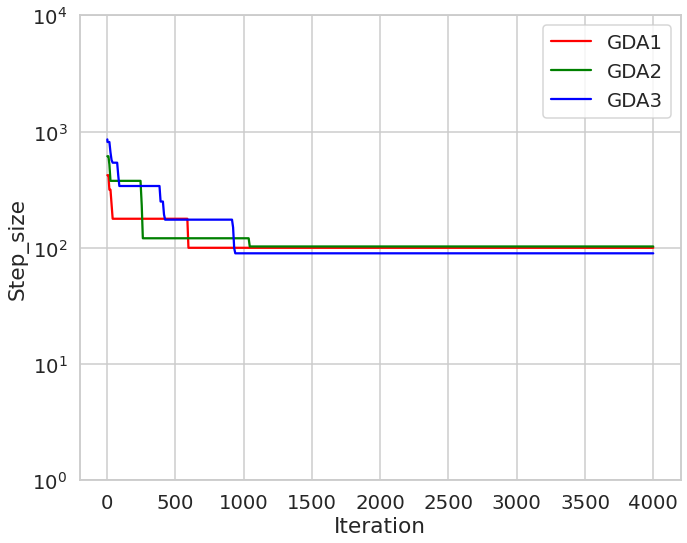

In [ ]:

fig, ax = plt.subplots(figsize=(10, 8))
# plt.figure(figsize=(10, 8))
plt.yscale('log')

ax.set_ylim(bottom=1, top=1e4)
my_green = sns.color_palette('bright')[2]
plt.xlabel('Iteration')
plt.ylabel(r'Step_size')
# plt.plot(adgd.its[2:], 1/L*np.ones(498), label='1/L', color='black')
# plt.plot(adgd.its[2:], 1/l2*np.ones(498), label=r'1/$\mu$')
# plt.plot(adgd.its[2:], adgd.lrs[2:], label='Adgd', color=my_green)
plt.plot(gda1.its[2:], gda1.lrs[2:], label='GDA1', color='red')
plt.plot(gda2.its[2:], gda2.lrs[2:], label='GDA2', color='green')
plt.plot(gda3.its[2:], gda3.lrs[2:], label='GDA3', color='blue')
plt.legend()
plt.tight_layout()
plt.show()
# print(len(gda.its))

#Run ANN models

In [ ]:
import numpy as np
import os
import torch
import torchvision
import random
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from pathlib import Path


def seed_everything(seed=1029):
    '''
    :param seed:
    :param device:
    :return:
    '''
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # some cudnn methods can be random even after fixing the seed
    # unless you tell it to be deterministic
    torch.backends.cudnn.deterministic = True


def load_data(dataset='cifar10', batch_size=128, num_workers=4):
    """
    Loads the required dataset
    :param dataset: Can be either 'cifar10' or 'cifar100'
    :param batch_size: The desired batch size
    :return: Tuple (train_loader, test_loader, num_classes)
    """
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    if dataset == 'cifar10':
        # classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        num_classes = 10
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    elif dataset == 'cifar100':
        num_classes = 100
        trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
        testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    else:
        raise ValueError('Only cifar 10 and cifar 100 are supported')

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return trainloader, testloader, num_classes


def accuracy_and_loss(net, dataloader, device, criterion):
    net.eval()
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss += criterion(outputs, labels).cpu().item() / len(dataloader)

    return correct / total, loss

def save_results(losses, test_losses, train_acc, test_acc, it_train, it_test, grad_norms, method='sgd',
                 lrs=[], experiment='cifar10_resnet18', folder='content/drive/MyDrive/Optimization', to_save_extra=[], prefixes_extra=[]):
    path = f'/{folder}/{experiment}/'
    Path(path).mkdir(parents=True, exist_ok=True)
    to_save = [losses, test_losses, train_acc, test_acc, it_train, it_test, grad_norms, lrs] + to_save_extra
    prefixes = ['l', 'tl', 'a', 'ta', 'itr', 'ite', 'gn', 'lr'] + prefixes_extra
    for log, prefix in zip(to_save, prefixes):
        np.save(f'{path}/{method}_{prefix}.npy', log)

def load_results(method, logs_path, load_lr=False):
    path = logs_path
    if logs_path[-1] != '/':
        path += '/'
    path += method + '_'
    prefixes = ['l', 'tl', 'a', 'ta', 'itr', 'ite', 'gn']
    if load_lr:
        prefixes += ['lr']
    out = [np.load(path + prefix + '.npy') for prefix in prefixes]
    return tuple(out)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

#ADGD

In [ ]:
import copy
def run_adgd(net, n_epoch=2, amplifier=0.02, damping=1, weight_decay=0, eps=1e-8, checkpoint=125, batch_size=128, noisy_train_stat=True):
    losses = []
    train_acc = []
    test_losses = []
    test_acc = []
    it_train = []
    it_test = []
    grad_norms = []

    prev_net = copy.deepcopy(net)
    prev_net.to(device)
    net.train()
    prev_net.train()
    lrs = []
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = Adsgd(net.parameters(), amplifier=amplifier, damping=damping, weight_decay=weight_decay, eps=eps)
    prev_optimizer = Adsgd(prev_net.parameters(), weight_decay=weight_decay)

    for epoch in range(n_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)
            prev_optimizer.zero_grad(set_to_none=True)

            prev_outputs = prev_net(inputs)
            prev_loss = criterion(prev_outputs, labels)
            prev_loss.backward()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.compute_dif_norms(prev_optimizer)
            prev_net.load_state_dict(net.state_dict())
            optimizer.step()

            running_loss += loss.item()
            if (i % 10) == 0:
                if noisy_train_stat:
                    losses.append(loss.cpu().item())
                    it_train.append(epoch + i * batch_size / N_train)
                lrs.append(optimizer.param_groups[0]['lr'])

            if i % checkpoint == checkpoint - 1:
                if running_loss / checkpoint < 0.01:
                    print('[%d, %5d] loss: %.4f' %
                          (epoch + 1, i + 1, running_loss / checkpoint), end='')
                else:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / checkpoint), end='')
                running_loss = 0.0
                test_a, test_l = accuracy_and_loss(net, testloader, device, criterion)
                test_acc.append(test_a)
                test_losses.append(test_l)
                grad_norms.append(np.sum([p.grad.data.norm().item() for p in net.parameters()]))
                net.train()
                it_test.append(epoch + i * batch_size / N_train)

        if not noisy_train_stat:
            it_train.append(epoch)
            train_a, train_l = accuracy_and_loss(net, trainloader, device, criterion)
            train_acc.append(train_a)
            losses.append(train_l)
            net.train()

    del prev_net
    return (np.array(losses), np.array(test_losses), np.array(train_acc), np.array(test_acc),
            np.array(it_train), np.array(it_test), np.array(lrs), np.array(grad_norms))


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
N_train = 50000
trainloader, testloader, num_classes = load_data(batch_size=128)
checkpoint = len(trainloader) // 3 + 1
amplifier = 0.02

n_seeds = 1
max_seed = 424242
rng = np.random.default_rng(42)
seeds = [rng.choice(max_seed, size=1, replace=False)[0] for _ in range(n_seeds)]
for r, seed in enumerate(seeds):
    seed_everything(seed)
    net = ResNet18()
    net.to(device)
    losses_adgd, test_losses_adgd, train_acc_adgd, test_acc_adgd, it_train_adgd, it_test_adgd, lrs_adgd, grad_norms_adgd = run_adgd(
        net=net, n_epoch=100, amplifier=0.02, damping=1, weight_decay=0,
        checkpoint=checkpoint, batch_size=128, noisy_train_stat=False
    )
    method = f'adgd_{0.02}_{1}'
    experiment = 'cifar10_resnet18'
    save_results(losses_adgd, test_losses_adgd, train_acc_adgd, test_acc_adgd, it_train_adgd, it_test_adgd, lrs=lrs_adgd,
                 grad_norms=grad_norms_adgd, method=method, experiment=experiment, folder='content/drive/MyDrive/Optimization')

cuda:0
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
[1,   131] loss: 1.939[1,   262] loss: 1.548[2,   131] loss: 1.265[2,   262] loss: 1.162[3,   131] loss: 1.007[3,   262] loss: 0.953[4,   131] loss: 0.844[4,   262] loss: 0.825[5,   131] loss: 0.738[5,   262] loss: 0.728[6,   131] loss: 0.654[6,   262] loss: 0.653[7,   131] loss: 0.565[7,   262] loss: 0.608[8,   131] loss: 0.542[8,   262] loss: 0.573[9,   131] loss: 0.518[9,   262] loss: 0.520[10,   131] loss: 0.475[10,   262] loss: 0.495[11,   131] loss: 0.478[11,   262] loss: 0.457[12,   131] loss: 0.449[12,   262] loss: 0.436[13,   131] loss: 0.426[13,   262] loss: 0.444[14,   131] loss: 0.422[14,   262] loss: 0.423[15,   131] loss: 0.375[15,   262] loss: 0.379[16,   131] loss: 0.404[16,   262] loss: 0.373[17,   131] loss: 0.376[17,   262] loss: 0.335[18,   131] loss: 0.371[18,   262] loss: 0.360[19,   131] loss: 0.280[19,   262] loss: 0.334[20,   131] loss: 0.304[20,   262] loss:

In [ ]:
# ['l', 'tl', 'a', 'ta', 'itr', 'ite', 'gn']
results_adgd = load_results(method=f'adgd_{0.02}_{1}', logs_path='/content/drive/MyDrive/Optimization/cifar10_resnet18', load_lr=True)

FileNotFoundError: ignored

In [ ]:
results_adgd[6]

NameError: ignored

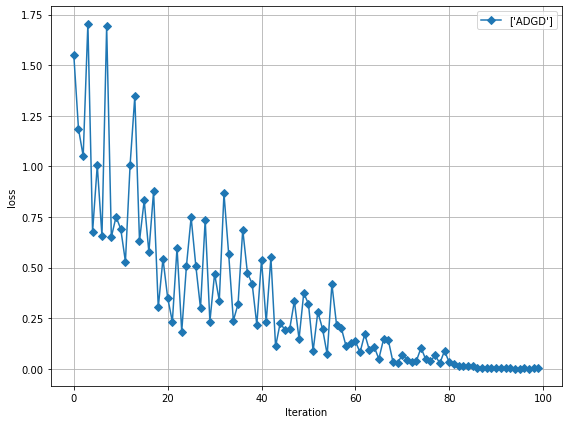

In [ ]:
markers = ['D', 'o', '*', '^', 'D', 's', '.', 'X']
plt.figure(figsize=(8, 6))
labels = ['ADGD']
plt.plot(results_adgd[4], results_adgd[0], label=labels, marker=markers[0])
# plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

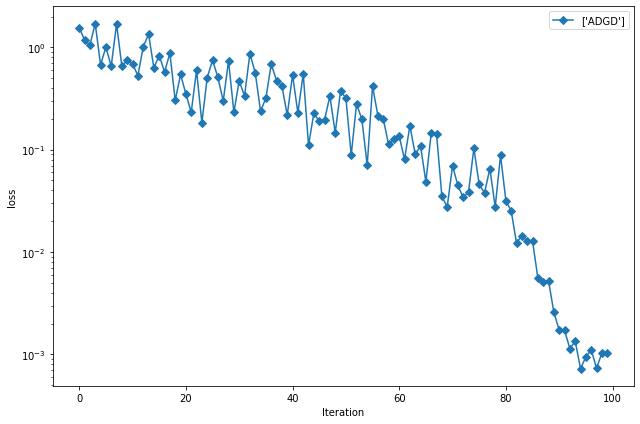

In [ ]:
markers = ['D', 'o', '*', '^', 'D', 's', '.', 'X']
plt.figure(figsize=(9, 6))
labels = ['ADGD']
plt.plot(results_adgd[4], results_adgd[0], label=labels, marker=markers[0])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'loss')
plt.legend()
plt.tight_layout()
plt.show()

#SGD

In [ ]:
import copy
def run_sgd(net, n_epoch=2, weight_decay=0, eps=1e-8, checkpoint=125, batch_size=128, noisy_train_stat=True):
    losses = []
    train_acc = []
    test_losses = []
    test_acc = []
    it_train = []
    it_test = []
    grad_norms = []

    prev_net = copy.deepcopy(net)
    prev_net.to(device)
    net.train()
    prev_net.train()
    lrs = []
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), weight_decay=weight_decay, lr=0.2)
    # prev_optimizer = torch.optim.SGD(prev_net.parameters(), weight_decay=weight_decay)

    for epoch in range(n_epoch):  # loop over the dataset multiple times

        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            start = time.time()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)
            # prev_optimizer.zero_grad(set_to_none=True)

            prev_outputs = prev_net(inputs)
            # prev_loss = criterion(prev_outputs, labels)
            # prev_loss.backward()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # optimizer.compute_dif_norms(prev_optimizer)
            # prev_net.load_state_dict(net.state_dict())
            optimizer.step()

            running_loss += loss.item()
            if (i % 10) == 0:
                if noisy_train_stat:
                    losses.append(loss.cpu().item())
                    it_train.append(epoch + i * batch_size / N_train)
                lrs.append(optimizer.param_groups[0]['lr'])

            if i % checkpoint == checkpoint - 1:
                if running_loss / checkpoint < 0.01:
                    print('[%d, %5d] loss: %.4f' %
                          (epoch + 1, i + 1, running_loss / checkpoint), end='')
                else:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / checkpoint), end='')
                running_loss = 0.0
                test_a, test_l = accuracy_and_loss(net, testloader, device, criterion)
                test_acc.append(test_a)
                test_losses.append(test_l)
                grad_norms.append(np.sum([p.grad.data.norm().item() for p in net.parameters()]))
                net.train()
                it_test.append(epoch + i * batch_size / N_train)
            # print(f'time: {time.time()-start}')
        if not noisy_train_stat:
            it_train.append(epoch)
            train_a, train_l = accuracy_and_loss(net, trainloader, device, criterion)
            train_acc.append(train_a)
            losses.append(train_l)
            net.train()

    # del prev_net
    return (np.array(losses), np.array(test_losses), np.array(train_acc), np.array(test_acc),
            np.array(it_train), np.array(it_test), np.array(lrs), np.array(grad_norms))


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
N_train = 50000
trainloader, testloader, num_classes = load_data(batch_size=128)
checkpoint = len(trainloader) // 3 + 1
# amplifier = 0.02

n_seeds = 1
max_seed = 424242
rng = np.random.default_rng(42)
seeds = [rng.choice(max_seed, size=1, replace=False)[0] for _ in range(n_seeds)]
for r, seed in enumerate(seeds):
    seed_everything(seed)
    net = ResNet18()
    net.to(device)
    losses_sgd, test_losses_sgd, train_acc_sgd, test_acc_sgd, it_train_sgd, it_test_sgd, lrs_sgd, grad_norms_sgd = run_sgd(
        net=net, n_epoch=100, weight_decay=0,
        checkpoint=checkpoint, batch_size=256, noisy_train_stat=False
    )
    method_sgd = f'sgd'
    experiment = 'cifar10_resnet18'
    save_results(losses_sgd, test_losses_sgd, train_acc_sgd, test_acc_sgd, it_train_sgd, it_test_sgd, lrs=lrs_sgd,
                 grad_norms=grad_norms_sgd, method=method_sgd, experiment=experiment, folder='content/drive/MyDrive/Optimization')

cuda:0
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
[1,   131] loss: 2.389[1,   262] loss: 1.769[2,   131] loss: 1.497[2,   262] loss: 1.408[3,   131] loss: 1.247[3,   262] loss: 1.175[4,   131] loss: 1.023[4,   262] loss: 0.997[5,   131] loss: 0.901[5,   262] loss: 0.861[6,   131] loss: 0.780[6,   262] loss: 0.756[7,   131] loss: 0.670[7,   262] loss: 0.674[8,   131] loss: 0.601[8,   262] loss: 0.597[9,   131] loss: 0.544[9,   262] loss: 0.540[10,   131] loss: 0.489[10,   262] loss: 0.490[11,   131] loss: 0.464[11,   262] loss: 0.446[12,   131] loss: 0.409[12,   262] loss: 0.413[13,   131] loss: 0.385[13,   262] loss: 0.394[14,   131] loss: 0.358[14,   262] loss: 0.367[15,   131] loss: 0.323[15,   262] loss: 0.344[16,   131] loss: 0.314[16,   262] loss: 0.311[17,   131] loss: 0.294[17,   262] loss: 0.303[18,   131] loss: 0.274[18,   262] loss: 0.285[19,   131] loss: 0.261[19,   262] loss: 0.266[20,   131] loss: 0.248[20,   262] loss:

In [ ]:
results_sgd = load_results(method=f'sgd', logs_path='/content/drive/MyDrive/Optimization/cifar10_resnet18', load_lr=True)

In [ ]:
results_sgd[7]

array([0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2])

In [ ]:
results_sgd[3]

array([0.341 , 0.3771, 0.4416, 0.4318, 0.5227, 0.5467, 0.6242, 0.6552,
       0.6421, 0.6651, 0.671 , 0.7011, 0.7225, 0.7626, 0.7629, 0.782 ,
       0.7205, 0.814 , 0.8043, 0.8096, 0.7965, 0.823 , 0.8097, 0.8121,
       0.744 , 0.8343, 0.8098, 0.8166, 0.8441, 0.8317, 0.8458, 0.8344,
       0.8499, 0.8521, 0.8486, 0.86  , 0.8371, 0.8595, 0.8579, 0.8585,
       0.8725, 0.8652, 0.8586, 0.8641, 0.8701, 0.8689, 0.8683, 0.8761,
       0.8813, 0.8819, 0.8805, 0.8904, 0.8795, 0.8863, 0.8862, 0.887 ,
       0.8866, 0.8926, 0.8941, 0.8773, 0.8892, 0.9   , 0.8786, 0.8897,
       0.8887, 0.874 , 0.8922, 0.885 , 0.8895, 0.8974, 0.8925, 0.8938,
       0.8946, 0.8877, 0.8945, 0.8886, 0.8974, 0.8928, 0.8925, 0.8936,
       0.8965, 0.9013, 0.892 , 0.892 , 0.9034, 0.8918, 0.8984, 0.906 ,
       0.9001, 0.8794, 0.9024, 0.9041, 0.9045, 0.9025, 0.8995, 0.9009,
       0.8925, 0.8985, 0.9022, 0.8926, 0.8992, 0.9053, 0.9031, 0.9036,
       0.9052, 0.9047, 0.9032, 0.9042, 0.9082, 0.8998, 0.9065, 0.9061,
      

In [ ]:
sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['mathtext.fontset'] = 'cm'

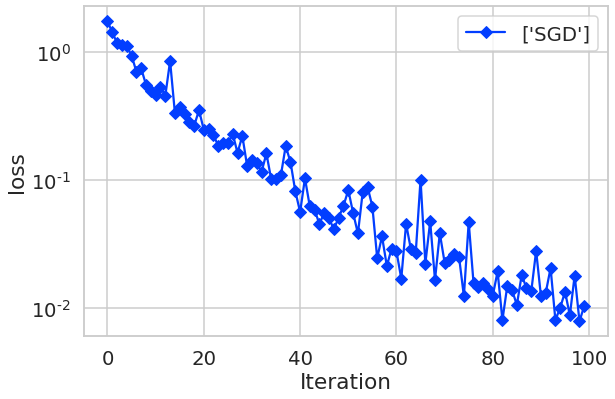

In [ ]:
markers = ['D', 'o', '*', '^', 'D', 's', '.', 'X']
plt.figure(figsize=(9, 6))
labels = ['SGD']
plt.plot(results_sgd[4], results_sgd[0], label=labels, marker=markers[0])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'loss')
plt.legend()
plt.tight_layout()
plt.show()

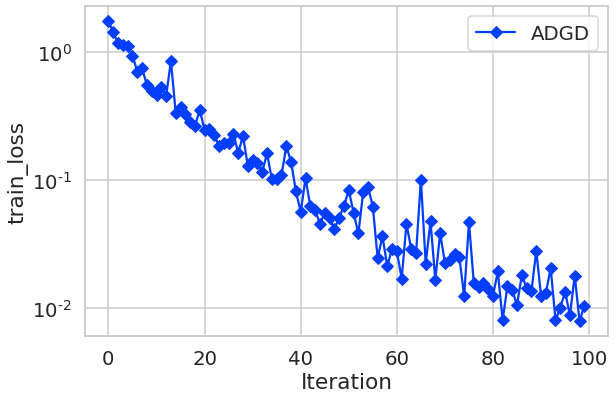

In [ ]:
markers = ['D', 'o']
plt.figure(figsize=(9, 6))
labels = ['ADGD', 'SGD']
results = [results_sgd]
for result, marker, label in zip(results, markers,labels):
  plt.plot(result[4], result[0], label=label, marker=marker)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'train_loss')
plt.legend()
plt.tight_layout()
plt.show()


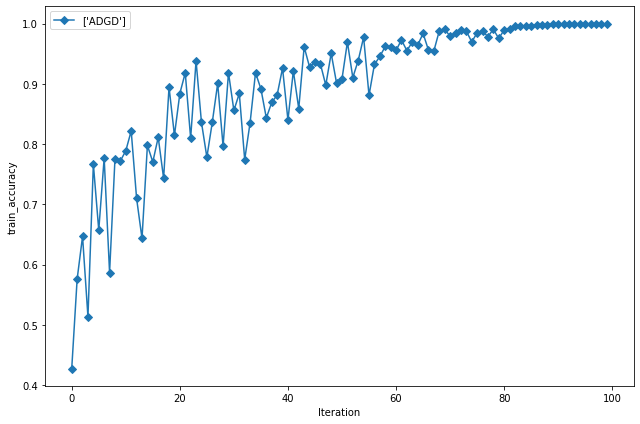

In [ ]:
markers = ['D', 'o', '*', '^', 'D', 's', '.', 'X']
plt.figure(figsize=(9, 6))
labels = ['ADGD']
plt.plot(results_adgd[4], results_adgd[2], label=labels, marker=markers[0])
# plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'train_accuracy')
plt.legend()
plt.tight_layout()
plt.show()

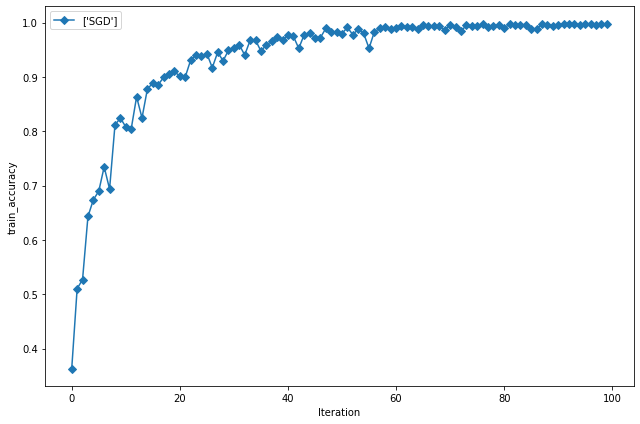

In [ ]:
markers = ['D', 'o', '*', '^', 'D', 's', '.', 'X']
plt.figure(figsize=(9, 6))
labels = ['SGD']
plt.plot(results_sgd[4], results_sgd[2], label=labels, marker=markers[0])
# plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'train_accuracy')
plt.legend()
plt.tight_layout()
plt.show()

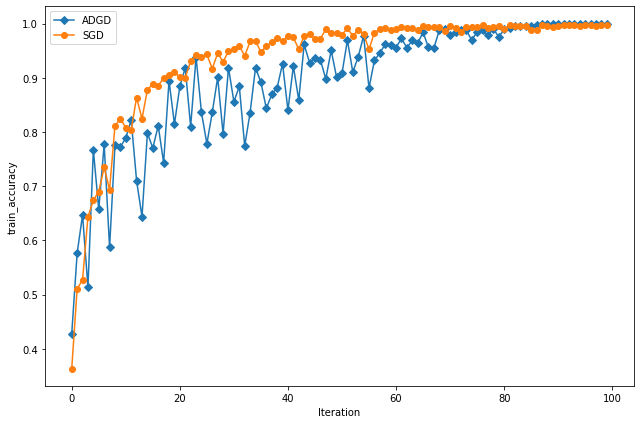

In [ ]:
markers = ['D', 'o']
plt.figure(figsize=(9, 6))
labels = ['ADGD', 'SGD']
results = [results_adgd, results_sgd]
for result, marker, label in zip(results, markers,labels):
  plt.plot(result[4], result[2], label=label, marker=marker)
# plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'train_accuracy')
plt.legend()
plt.tight_layout()
plt.show()


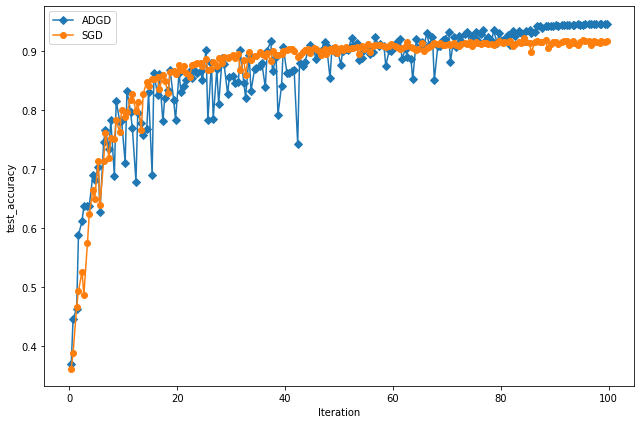

In [ ]:
markers = ['D', 'o']
plt.figure(figsize=(9, 6))
labels = ['ADGD', 'SGD']
results = [results_adgd, results_sgd]
for result, marker, label in zip(results, markers,labels):
  plt.plot(result[5], result[3], label=label, marker=marker)
# plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'test_accuracy')
plt.legend()
plt.tight_layout()
plt.show()


#GDA

In [ ]:
import time

In [ ]:
def run_gda(net, n_epoch=2, weight_decay=0, eps=1e-8, sigma=0.1,lr=0.2, k=0.75,checkpoint=125, batch_size=128, noisy_train_stat=True):
    losses = []
    train_acc = []
    test_losses = []
    test_acc = []
    it_train = []
    it_test = []
    grad_norms = []

    net.train()
    lrs = []
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), weight_decay=weight_decay, lr=0.2)
    # prev_optimizer = torch.optim.SGD(prev_net.parameters(), weight_decay=weight_decay)

    for epoch in range(n_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            e = 0

            for p in net.parameters():

              # print(p.data)
              if p.requires_grad is False:
                    continue
              # start = time.time()
              dp = p.grad
              # print(f'p:{p}')
              p_pre = p.data.clone()
              p.data = p.data - lr*dp

              e += torch.matmul(dp.flatten(),(p_pre - p.data).flatten())
              p.grad.zero_()

            dl = criterion(net(inputs), labels)
            if dl.item() - loss.item() + sigma*(e) <= 0:
               lr = lr
            else:
               print('Learning rate gets updated')
               lr = k*lr

            running_loss += loss.item()

            if (i % 10) == 0:
                if noisy_train_stat:
                    losses.append(loss.cpu().item())
                    it_train.append(epoch + i * batch_size / N_train)
                lrs.append(lr)
                # print(lrs)

            if i % checkpoint == checkpoint - 1:
                if running_loss / checkpoint < 0.01:
                    print('[%d, %5d] loss: %.4f' %
                          (epoch + 1, i + 1, running_loss / checkpoint), end='')
                else:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / checkpoint), end='')
                # print(f'time: {time.time()-start}')
                running_loss = 0.0
                test_a, test_l = accuracy_and_loss(net, testloader, device, criterion)
                # print(f'time: {time.time()-start}')
                test_acc.append(test_a)
                test_losses.append(test_l)
                # grad_norms.append(np.sum([p.grad.data.norm().item() for p in net.parameters()]))
                net.train()
                it_test.append(epoch + i * batch_size / N_train)

        if not noisy_train_stat:
            it_train.append(epoch)
            train_a, train_l = accuracy_and_loss(net, trainloader, device, criterion)
            train_acc.append(train_a)
            losses.append(train_l)
            net.train()

    # del prev_net
    return (np.array(losses), np.array(test_losses), np.array(train_acc), np.array(test_acc),
            np.array(it_train), np.array(it_test), np.array(lrs), np.array(grad_norms))


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
N_train = 50000
trainloader, testloader, num_classes = load_data(batch_size=128)
checkpoint = len(trainloader) // 3 + 1

n_seeds = 1
max_seed = 424242
rng = np.random.default_rng(42)
seeds = [rng.choice(max_seed, size=1, replace=False)[0] for _ in range(n_seeds)]
for r, seed in enumerate(seeds):
    seed_everything(seed)
    net = ResNet18()
    net.to(device)
    losses_gda, test_losses_gda, train_acc_gda, test_acc_gda, it_train_gda, it_test_gda, lrs_gda, grad_norms_gda = run_gda(
        net=net, n_epoch=100, weight_decay=0,
        checkpoint=checkpoint, batch_size=256, noisy_train_stat=False
    )
    method = f'gda_{0.2}_{0.1}_{0.75}' #lr k
    experiment = 'cifar10_resnet18'
    # save_results(losses_gda, test_losses_gda, train_acc_gda, test_acc_gda, it_train_gda, it_test_gda, lrs=lrs_gda,
                #  grad_norms=grad_norms_gda, method=method, experiment=experiment, folder='content/drive/MyDrive/Optimization')

cuda:0
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Learning rate gets updated
Learning rate gets updated
Learning rate gets updated
Learning rate gets updated
[1,   131] loss: 2.184[1,   262] loss: 1.644[2,   131] loss: 1.370[2,   262] loss: 1.269[3,   131] loss: 1.076[3,   262] loss: 1.006[4,   131] loss: 0.860[4,   262] loss: 0.819[5,   131] loss: 0.716[5,   262] loss: 0.678[6,   131] loss: 0.602[6,   262] loss: 0.592[7,   131] loss: 0.531[7,   262] loss: 0.540[8,   131] loss: 0.479[8,   262] loss: 0.478[9,   131] loss: 0.441[9,   262] loss: 0.439[10,   131] loss: 0.393[10,   262] loss: 0.400[11,   131] loss: 0.374[11,   262] loss: 0.361[12,   131] loss: 0.338[12,   262] loss: 0.335[13,   131] loss: 0.308[13,   262] loss: 0.325[14,   131] loss: 0.292[14,   262] loss: 0.303[15,   131] loss: 0.263[15,   262] loss: 0.281[16,   131] loss: 0.256[16,   262] loss: 0.257[17,   131] loss: 0.236[17,   262] loss: 0.251[18,   131] loss: 0.222[

In [ ]:
save_results(losses_gda, test_losses_gda, train_acc_gda, test_acc_gda, it_train_gda, it_test_gda, lrs=lrs_gda,
                 grad_norms=grad_norms_gda, method=method, experiment=experiment, folder='content/drive/MyDrive/Optimization')

In [ ]:
results_gda = load_results(method=f'gda_{0.2}_{0.1}_{0.75}', logs_path='/content/drive/MyDrive/Optimization/cifar10_resnet18', load_lr=True)

In [ ]:
results_gda[7]

array([0.15      , 0.06328125, 0.06328125, ..., 0.00844703, 0.00844703,
       0.00844703])

In [ ]:
import seaborn as sns
import matplotlib

In [ ]:
sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['mathtext.fontset'] = 'cm'

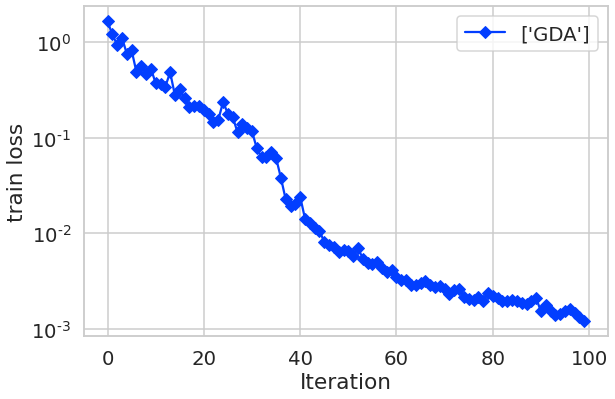

In [ ]:
markers = ['D', 'o', '*', '^', 'D', 's', '.', 'X']
plt.figure(figsize=(9, 6))
labels = ['GDA']
plt.plot(results_gda[4], results_gda[0], label=labels, marker=markers[0])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'train loss')
plt.legend()
plt.tight_layout()
plt.show()

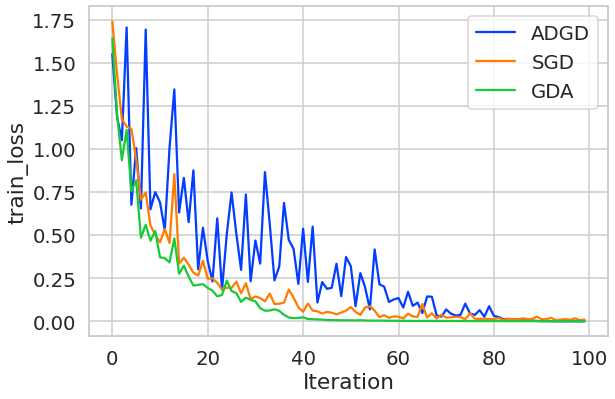

In [ ]:
markers = ['D', 'o', '*']
plt.figure(figsize=(9, 6))
labels = ['ADGD', 'SGD', 'GDA']
results = [results_adgd, results_sgd, results_gda]
for result, marker, label in zip(results, markers,labels):
  plt.plot(result[4], result[0], label=label)
# plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'train_loss')
plt.legend()
# plt.grid()
plt.tight_layout()
plt.show()


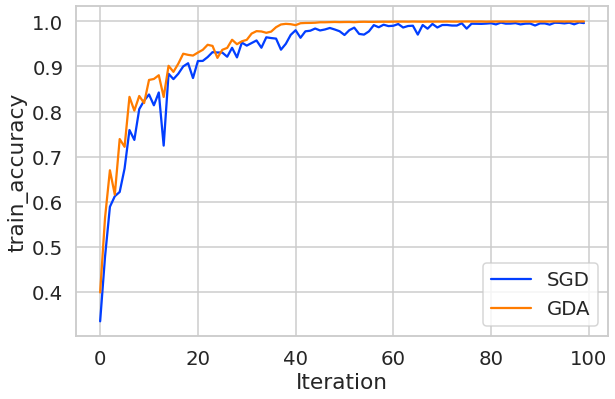

In [ ]:
markers = ['D', 'o', '*']
plt.figure(figsize=(9, 6))
labels = ['SGD', 'GDA']
results = [ results_sgd, results_gda]
for result, marker, label in zip(results, markers,labels):
  plt.plot(result[4], result[2], label=label)
# plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'train_accuracy')
plt.legend()
plt.tight_layout()
plt.show()


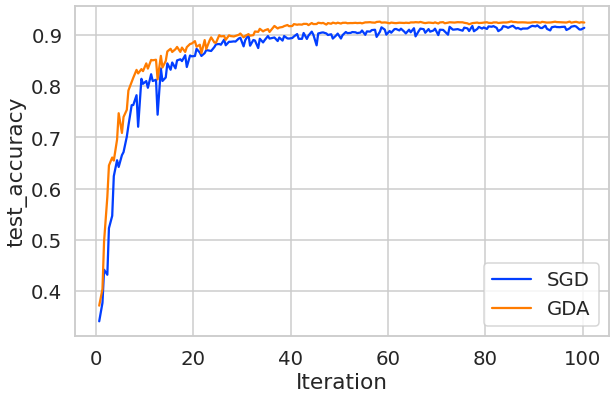

In [ ]:
markers = ['D', 'o', '*']
plt.figure(figsize=(9, 6))
labels = [ 'SGD', 'GDA']
results = [results_sgd, results_gda]
for result, marker, label in zip(results, markers,labels):
  plt.plot(result[5], result[3], label=label)
#plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'test_accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
len(results_sgd[7])

4000

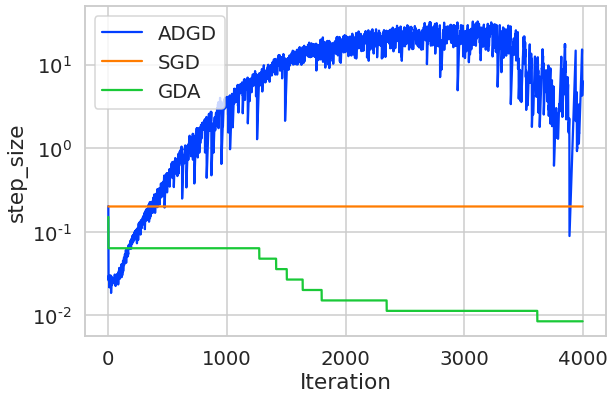

In [ ]:
markers = ['D', 'o', '*']
plt.figure(figsize=(9, 6))
labels = ['ADGD', 'SGD', 'GDA']
it = np.arange(4000)
results = [results_adgd, results_sgd, results_gda]
for result, marker, label in zip(results, markers,labels):
  plt.plot(it, result[7], label=label)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'step_size')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
gdb = Gd_B(1/L, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
gdb.run(w0=w0)

In [ ]:
optimizers = [gdb]
markers = ['D', 'o', '*', '^', 'D', 's', '.', 'X']

for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
# f_star = np.min([np.min(opt.losses) for opt in optimizers])
f_star = 0.6
print(f_star)
plt.figure(figsize=(8, 6))
labels = ['GDB']
for opt, marker, label in zip(optimizers, markers + ['.', 'X'], labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
gd = Gd(lr=1 / L, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
gd.run(w0=w0)

In [ ]:
optimizers = [gd]
markers = ['D', 'o', '*', '^', 'D', 's', '.', 'X']

for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
# f_star = np.min([np.min(opt.losses) for opt in optimizers])
f_star = 0.6
print(f_star)
plt.figure(figsize=(8, 6))
labels = ['GD']
for opt, marker, label in zip(optimizers, markers + ['.', 'X'], labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
gda = Gd_A(lr=10 / L, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
gda.run(w0=w0)

In [ ]:
optimizers = [gda]
markers = ['D', 'o', '*', '^', 'D', 's', '.', 'X']

for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
f_star = np.min([np.min(opt.losses) for opt in optimizers])
print(f_star)
plt.figure(figsize=(8, 6))
labels = ['GDA']
for opt, marker, label in zip(optimizers, markers + ['.', 'X'], labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
adgd = Adgd(loss_func=loss_func, grad_func=grad_func, eps=0, it_max=it_max)
adgd.run(w0=w0)

In [ ]:
optimizers = [adgd]
markers = ['D', 'o', '*', '^', 'D', 's', '.', 'X']

for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
f_star = np.min([np.min(opt.losses) for opt in optimizers])
print(f_star)
plt.figure(figsize=(8, 6))
labels = ['GDA']
for opt, marker, label in zip(optimizers, markers + ['.', 'X'], labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
optimizers = [gd,gdb]
markers = ['D', 'o', '*', '^', 'D', 's', '.', 'X']

for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
# f_star = np.min([np.min(opt.losses) for opt in optimizers])
print(f_star)
f_star = 0.6
plt.figure(figsize=(8, 6))
labels = ['GD','GDA', 'ADGD']
for opt, marker, label in zip(optimizers, ['.', 'X','*'], labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# nest = Nesterov(lr=1 / L, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
# nest.run(w0=w0)

In [ ]:
# nest_str = Nesterov(lr=1 / L, strongly_convex=True, mu=l2, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
# nest_str.run(w0=w0)

In [ ]:
# adgd = Adgd(loss_func=loss_func, grad_func=grad_func, eps=0, it_max=it_max)
# adgd.run(w0=w0)

In [ ]:
# ad_acc = AdgdAccel(loss_func=loss_func, grad_func=grad_func, it_max=it_max)
# ad_acc.run(w0=w0)

In [ ]:
# optimizers = [gd, nest, adgd, ad_acc, nest_str]
# markers = [',', 'o', '*', '^', 'D', 's', '.', 'X']

# for opt, marker in zip(optimizers, markers):
#     opt.compute_loss_on_iterates()
# f_star = np.min([np.min(opt.losses) for opt in optimizers])

# plt.figure(figsize=(8, 6))
# labels = ['GD', 'Nesterov', 'AdGD', 'AdGD-accel', 'Nesterov-strong']
# for opt, marker, label in zip(optimizers, markers + ['.', 'X'], labels):
#     opt.plot_losses(marker=marker, f_star=None, label=label)
# plt.yscale('log')
# plt.xlabel('Iteration')
# plt.ylabel(r'$f(x^k) - f_*$')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# adgd = Adgd(loss_func=loss_func, grad_func=grad_func, eps=0, it_max=500)
# adgd.run(w0=w0)
# plt.figure(figsize=(8, 6))
# my_green = sns.color_palette('bright')[2]
# plt.plot(adgd.its[2:], adgd.lrs[2:], label='AdGD', color=my_green)
# plt.axhline(y=1 / L, color='black', label='$1/L$')
# plt.axhline(y=1 / l2, color='red', label='$1/\mu$')
# plt.yscale('log')
# plt.xlabel('Iteration')
# plt.ylabel('$\lambda_k$')
# plt.legend()
# plt.tight_layout()
# plt.show()